PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


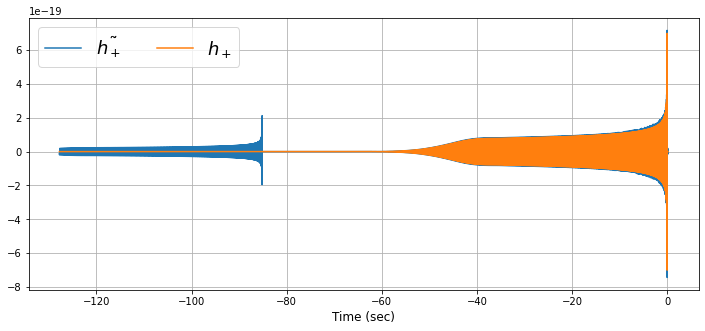

In [ ]:
# Splitting the polarizations of the gravitational-wave signal as viewed from the line of sight at a given source inclination (assumed face-on if not provided)

from pycbc import waveform
import pylab
from lgw import *

source_ra=1.1
source_dec=1.1
lens_ra=0.1
lens_dec=0.2
zs=1.0
zl=0.5
ml=1e6
lens_model_list=['POINT_MASS']
mass1=30
mass2=30
delta_t=1.0/16384
f_lower=5
optim='False'

waveform.add_custom_waveform('lensed', lensed_gw_td, 'time', force=True)
hp_tilde_lensed, hc_tilde_lensed = waveform.get_td_waveform(
                approximant="lensed", source_ra=source_ra, source_dec=source_dec, 
                lens_ra=lens_ra, lens_dec=lens_dec, 
                zs=zs, zl=zl, ml=ml, lens_model_list=lens_model_list,
                mass1=mass1, mass2=mass2, delta_t=delta_t, f_lower=f_lower, optim=optim)

hp, hc = waveform.get_td_waveform(approximant='IMRPhenomD', mass1=mass1, mass2=mass2, delta_t=delta_t, f_lower=f_lower)
hp_tilde_lensed.start_time = hp.start_time
pylab.figure(figsize=(12,5))
pylab.xlabel('Time (sec)',fontsize=12)
pylab.plot(hp_tilde_lensed.sample_times, hp_tilde_lensed,label='$\\tilde{h_+}$')
pylab.plot(hp.sample_times, hp, label='$h_+$')
pylab.legend(ncol=2, fontsize=18)
pylab.grid()

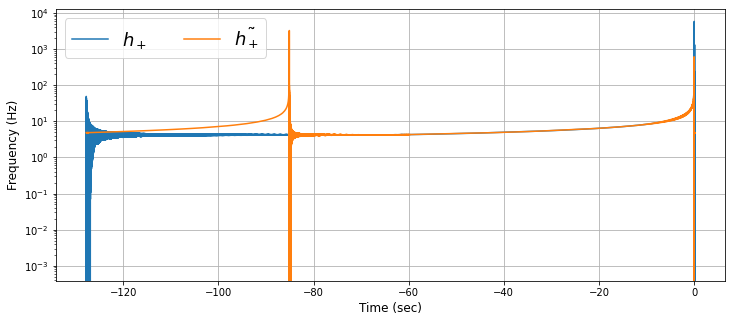

In [ ]:
#Mapping polarization across the frequency domain

freq = waveform.frequency_from_polarizations(hp, hc)
freq_tilde = waveform.frequency_from_polarizations(hp_tilde_lensed, hc_tilde_lensed)
pylab.figure(figsize=(12,5))
pylab.plot(hp.sample_times[:-1],freq, label='$h_+$')
pylab.plot(hp_tilde_lensed.sample_times[:-1],freq_tilde, label='$\\tilde{h_+}$')
pylab.legend(ncol=2, fontsize=18)
pylab.xlabel('Time (sec)',fontsize=12)
pylab.ylabel('Frequency (Hz)',fontsize=12)
pylab.grid()
pylab.yscale('log')

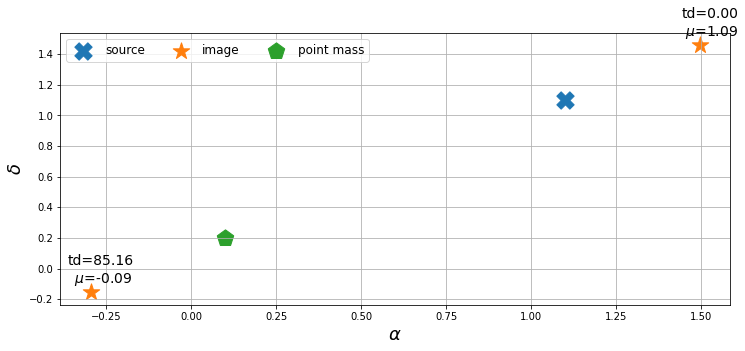

In [ ]:
#Visualizing the time delay in the arrival of the lensed gravitational wave

from lensGW.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
Img_ra, Img_dec, kwargs_lens_list, solver_kwargs = lens_waveform_model(None).eval_param(
                source_ra=source_ra, source_dec=source_dec, 
                lens_ra=[lens_ra], lens_dec=[lens_dec], 
                zS=zs, zL=zl, mL=[ml], lens_model_list=lens_model_list, optim=optim)

td = TimeDelay(Img_ra, Img_dec,
            source_pos_x=source_ra, source_pos_y=source_dec,
            zS=zs, zL=zl, lens_model_list=lens_model_list, kwargs_lens_list=kwargs_lens_list,
            scaled=solver_kwargs['Scaled'], scale_factor=solver_kwargs['ScaleFactor'])

mus = magnifications (Img_ra, Img_dec, lens_model_list, kwargs_lens_list)
pylab.figure(figsize=(12,5))
pylab.scatter(source_ra, source_dec, marker='X',s=300, label='source')
pylab.scatter(Img_ra, Img_dec, marker='*',s=300, label='image')
pylab.scatter(lens_ra, lens_dec, marker='p',s=300, label='point mass')
pylab.legend(fontsize=12,ncol=3)
pylab.grid()
pylab.xlabel('$\\alpha$',fontsize=18)
pylab.ylabel('$\delta$',fontsize=18)
i=0
for x,y in zip(Img_ra, Img_dec):
    label = "td={:.2f}\n $\mu$={:.2f}".format(td[i],mus[i])
    pylab.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center',
                 fontsize=14) # horizontal alignment can be left, right or center
    i+=1

In [4]:
injection_config="""
[variable_params]

[static_params]
tc = 1126259462.420
approximant=lgw
;lens param
;
source_ra=1.1
source_dec=1.1
lens_ra=0.1
lens_dec=0.2
zs=1.0
zl=0.5
ml=1e6
lens_model_list=['POINT_MASS']
optim=True
;
;wave - param
;
mass1=30
mass2=30
inclination=0
f_lower=5
eccentricity=0

;detector - config
ra = 1.1
dec= 1.1
polarization = 1.75

"""
!echo '{injection_config}' > injection.ini

In [ ]:
%%shell

pycbc_create_injections --verbose \
            --config-files injection.ini \
            --ninjections 1 \
            --seed 123 \
            --output-file injection.hdf \
            --variable-params-section variable_params \
            --static-params-section static_params \
            --dist-section prior \
            --force

pycbc_condition_strain --sample-rate 16384\
            --gps-start-time 1126259100\
            --gps-end-time 1126259600\
            --fake-strain /content/sensitivity-curves/voyager.txt \
            --fake-strain-flow 10\
            --injection-file injection.hdf\
            --channel-name H1:STRAIN\
            --fake-strain-seed 44\
            --output-strain-file strain.hdf

In [ ]:
#Calculating the signal-to-noise (SNR) ratio

import h5py
import numpy as np
from pycbc.types import TimeSeries
from pycbc.filter import resample_to_delta_t, highpass, matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

source_ra=1.1
source_dec=1.1
lens_ra=0.1
lens_dec=0.2
zs=1.0
zl=0.5
ml=1e5
lens_model_list=['POINT_MASS']
mass1=30
mass2=30

hf = h5py.File("strain.hdf",'r')
key = 'H1:STRAIN'
strain_H1 = TimeSeries(np.array(hf.get(key)),delta_t=1/16384)
strain_H1.start_time += 1126259250

strain = resample_to_delta_t(highpass(strain_H1, 8.0), 1.0/4096)
conditioned = strain_H1.crop(350,10)
low_frequency_cutoff = 10

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                low_frequency_cutoff=low_frequency_cutoff)

waveform.add_custom_waveform('lensed', lensed_gw_td, 'time', force=True)
hp,hc = waveform.get_td_waveform(approximant="lensed", source_ra=source_ra, source_dec=source_dec, 
                lens_ra=lens_ra, lens_dec=lens_dec, 
                zs=zs, zl=zl, ml=ml, lens_model_list=lens_model_list,
                mass1=mass1, mass2=mass2, f_lower=f_lower, optim=optim,
                delta_t=conditioned.delta_t)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned,psd=psd, low_frequency_cutoff=low_frequency_cutoff)
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("{} with SNR {}".format(time, abs(snrp)))

1126259667.2382812 with SNR 40530.3744560593


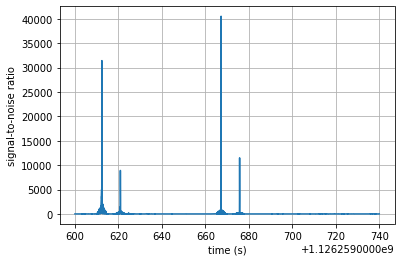

In [ ]:
#Visualizing the signal-to-noise ratio

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.grid()
pylab.show()

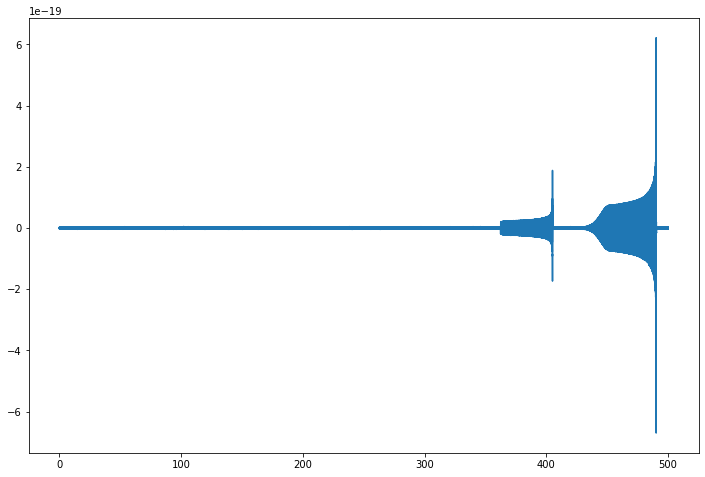

In [ ]:
#Obtaining the strain polarization of the lensed gravitational wave

hf = h5py.File("strain.hdf",'r')
key = 'H1:STRAIN'
strain_H1 = TimeSeries(np.array(hf.get(key)),delta_t=1/16384)
pylab.figure(figsize=(12,8))
pylab.plot(strain_H1.sample_times, strain_H1)